In [1]:
import os
import sys
import time
import glob
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

In [10]:
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import os

save_dir = "/Users/neeravkaushal/Codes/diffusion/data/mnist/train"
os.makedirs(save_dir, exist_ok=True)
transform = transforms.ToTensor()
mnist_dataset = MNIST(root='./data', train=True, transform=transform, download=True)

for i, (image, label) in enumerate(mnist_dataset):
    image_path = os.path.join(save_dir, f"mnist_{i}.png")
    torchvision.utils.save_image(image, image_path)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100.0%
100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
torchvision.datasets.MNIST(
    root="/Users/neeravkaushal/Codes/diffusion/data/mnist",
    train=True,
    transform=transforms.ToTensor(),
    target_transform=True,
    download=True)

6.6%

100.0%


Extracting /Users/neeravkaushal/Codes/diffusion/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /Users/neeravkaushal/Codes/diffusion/data/mnist/MNIST/raw



100.0%

Extracting /Users/neeravkaushal/Codes/diffusion/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/neeravkaushal/Codes/diffusion/data/mnist/MNIST/raw




100.0%
100.0%


Extracting /Users/neeravkaushal/Codes/diffusion/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/neeravkaushal/Codes/diffusion/data/mnist/MNIST/raw

Extracting /Users/neeravkaushal/Codes/diffusion/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/neeravkaushal/Codes/diffusion/data/mnist/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/neeravkaushal/Codes/diffusion/data/mnist
    Split: Train
    StandardTransform
Transform: ToTensor()
Target transform: True

In [2]:
def show_images(dataset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(12,12)) 
    for i, image in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(to_pil_image(dataset[i]))

class MyCustomDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.image_paths = os.listdir(data_folder)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.image_paths[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
# image_size = [128,128]

# my_transforms = transforms.Compose([
#                     transforms.Resize(image_size),
#                     #---random crop
#                     #transforms.RandomHorizontalFlip(p=0.4),
#                     #transforms.RandomVerticalFlip(p=0.4),
#                     transforms.ToTensor(),
#                     #transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
#                     transforms.Lambda(lambda t: (t * 2) - 1)
#                     ])

# my_dataset = MyCustomDataset(data_folder="/Users/neeravkaushal/Codes/Diffusion/stanford_cars_dataset/train",
#                              transform=my_transforms)
# my_dataloader = DataLoader(my_dataset, batch_size=4, shuffle=True)

# print('Total samples:', len(my_dataset))
# print('Sample shape:', my_dataset[0].shape)

# show_images(dataset=my_dataset, num_samples=9, cols=3)

In [3]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Returns a list of beta schedules
    """
    return torch.linspace(start, end, timesteps)

# def cosine_beta_schedule(timesteps, start=0.0001, end=0.02):
#     """
#     Returns a list of beta schedules following a cosine annealing schedule.
    
#     Args:
#     - timesteps (int): Number of timesteps for the scheduler
#     - start (float): Initial value of beta
#     - end (float): Final value of beta
    
#     Returns:
#     - torch.Tensor: A tensor representing the beta schedule
#     """
#     betas = torch.linspace(start, end, timesteps)
#     cos_schedule = 0.5 * (1.0 + torch.cos(torch.linspace(0, 2 * torch.pi, timesteps)))
#     return start + (end - start) * cos_schedule

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [4]:
T = 200 #---timesteps
betas  =  linear_beta_schedule(timesteps=T, start=0.0001, end=0.02) #---betas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

#betas2  =  cosine_beta_schedule(timesteps=T) #---betas
#print('betas:', betas, '\n')
#print('alphas:', alphas, '\n')
#print('alphas_cumprod:', alphas_cumprod, '\n')
#print('alphas_cumprod_prev:', alphas_cumprod_prev, '\n')

In [5]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 128
BATCH_SIZE = 8

def load_transformed_dataset():
    my_transforms = transforms.Compose([
                        transforms.Resize([IMG_SIZE,IMG_SIZE]),
                        #---random crop
                        #transforms.RandomHorizontalFlip(p=0.4),
                        #transforms.RandomVerticalFlip(p=0.4),
                        transforms.ToTensor(),
                        #transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                        transforms.Lambda(lambda t: (t * 2) - 1)
                    ])
    train_dataset = MyCustomDataset(data_folder="/Users/neeravkaushal/Codes/Diffusion/stanford_cars_dataset/train", transform=my_transforms)
    test_dataset  = MyCustomDataset(data_folder="/Users/neeravkaushal/Codes/Diffusion/stanford_cars_dataset/test" , transform=my_transforms)
    return torch.utils.data.ConcatDataset([train_dataset, test_dataset])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
                            transforms.Lambda(lambda t: (t + 1) / 2),
                            transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
                            transforms.Lambda(lambda t: t * 255.),
                            transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
                            transforms.ToPILImage(),])
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/var/folders/43/8014g22j3k98xdzy9b0rvc_m0000gn/T/ipykernel_45694/415208797.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
/var/folders/43/8014g22j3k98xdzy9b0rvc_m0000gn/T/ipykernel_45694/699168437.py:27: RuntimeWarning: invalid value encountered in cast
  transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),


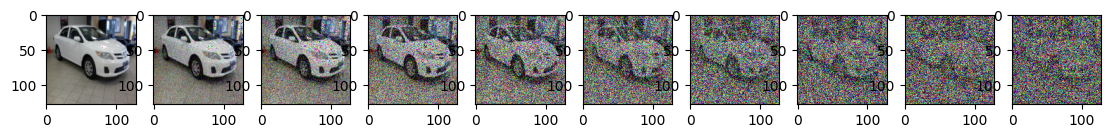

In [6]:
# Simulate noising aka forward diffusion
image = next(iter(dataloader))[0]
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    #print(img.shape, noise.shape)
    show_tensor_image(img)

In [7]:
from torch import nn
import math

class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transconv = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transconv = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x))) # First Conv
        time_emb = self.relu(self.time_mlp(t)) # Time embedding
        time_emb = time_emb[(..., ) + (None, ) * 2] # Extend last 2 dimensions
        h += time_emb # Add time channel
        
        h = self.bnorm2(self.relu(self.conv2(h))) # Second Conv
        return self.transconv(h) # Down or Upsample


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels  = (64, 128, 256, 512, 1024)
        up_channels    = (1024, 512, 256, 128, 64)
        out_dim        = 3 
        time_emb_dim   = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        # Downsample
        self.downs = nn.ModuleList([UNetBlock(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([UNetBlock(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        
        t = self.time_mlp(timestep) # Embed time
        x = self.conv0(x) # Initial conv
        
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1) # Add residual x as additional channels         
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): UNetBlock(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transconv): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): UNetBlock(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (

In [8]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [9]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t                         = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t             = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    model_mean                      = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t) # Call model (current image - noise prediction)
    posterior_variance_t            = get_index_from_list(posterior_variance, t, x.shape)
    if t == 0:
        return model_mean # As pointed out by Luis Pereira (see YouTube comment), the t's are offset from the t's in the paper
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img      = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

Epoch 0 | step 000 Loss: 0.8093113899230957 


RuntimeError: index 1041274648 is out of bounds for dimension 0 with size 200

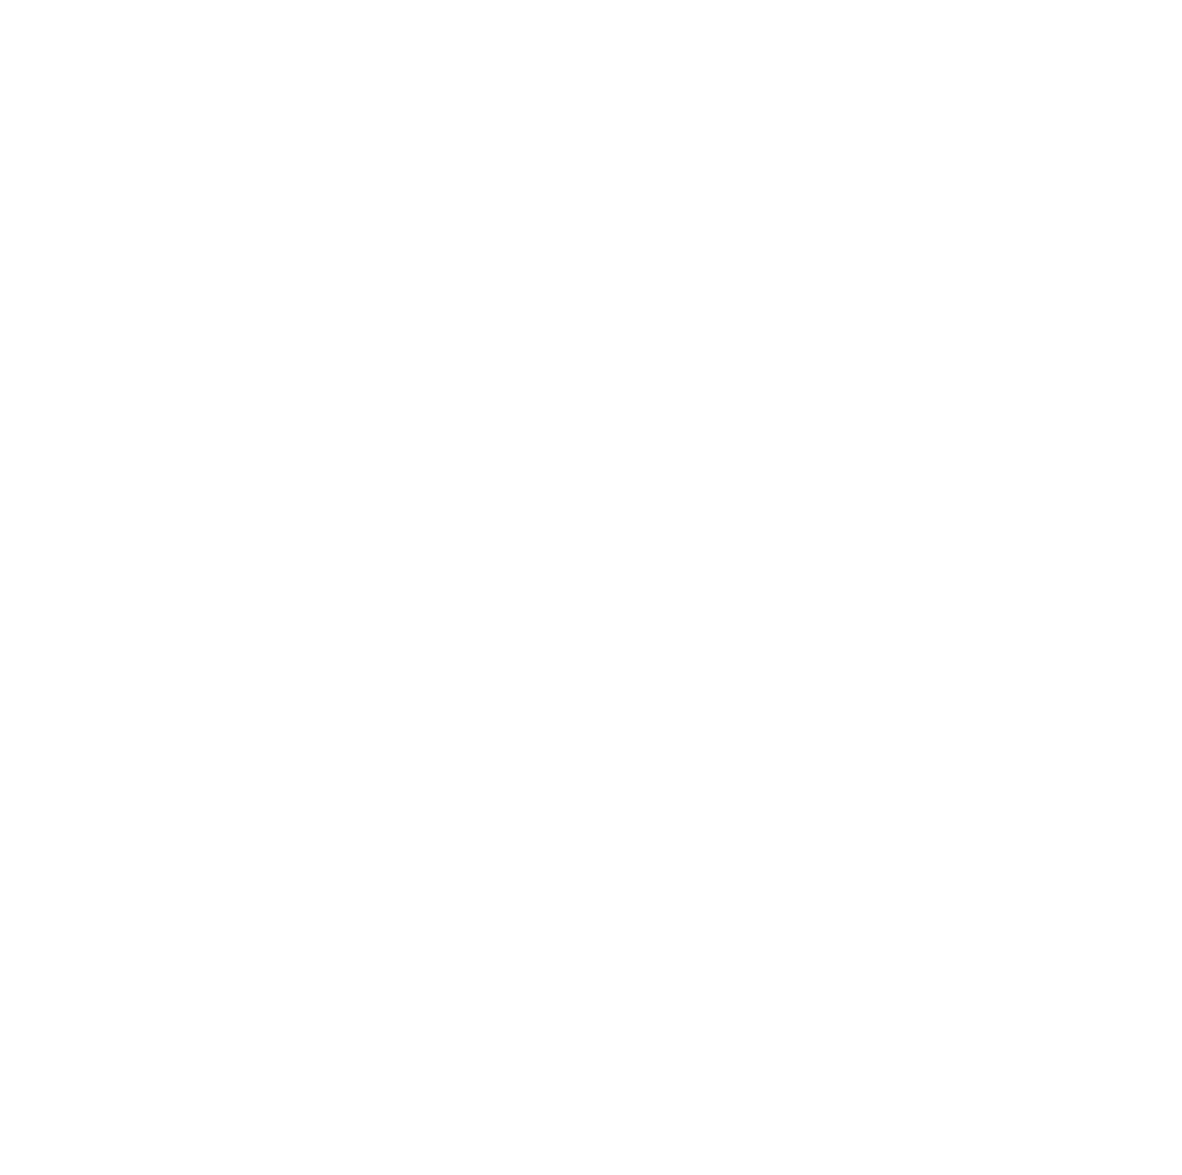

In [10]:
from torch.optim import Adam
#device= "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      #print(batch.shape)
      optimizer.zero_grad()
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch, t)
      loss.backward()
      optimizer.step()
      #if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      sample_plot_image()